<a href="https://colab.research.google.com/github/Fabchirajoul/Transformer_MLM_AND_BINARY_CLASSIFICATION/blob/main/MLM_WAYNE_HUGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# pip install accelerate -U

In [2]:
# pip install transformers

In [3]:
# pip install datasets

In [4]:
from google.colab import files

# Upload an image file
uploaded_workflow = files.upload()

Saving workflow.JPG to workflow (1).JPG


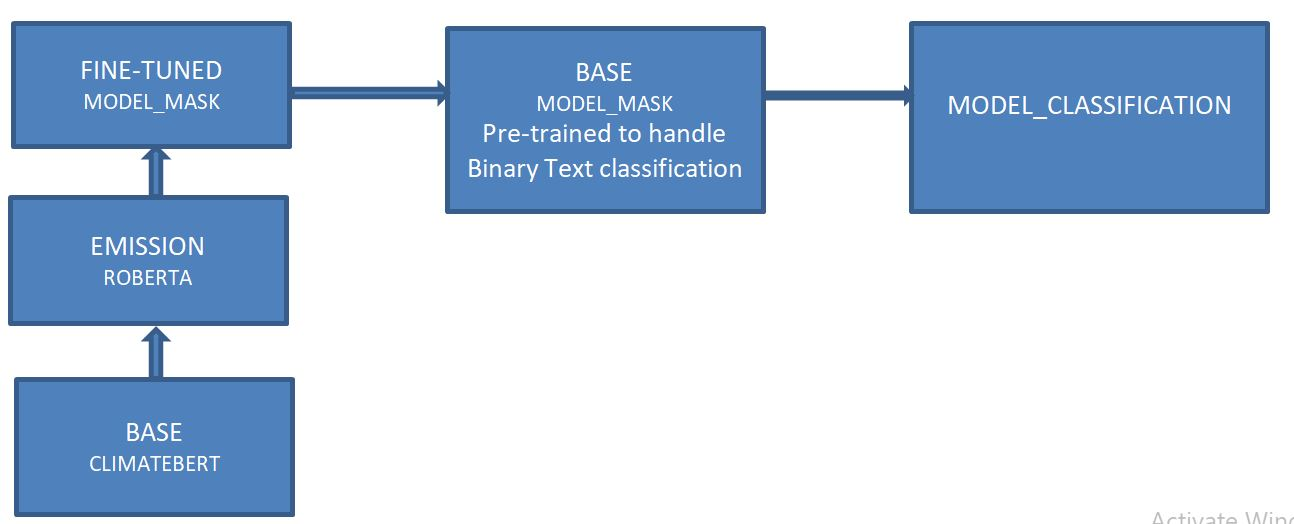

In [5]:
# Get the file name
workflow = list(uploaded_workflow.keys())[0]

# Display the uploaded image
from IPython.display import Image
Image(workflow)

# First we need to create a function that will randomly divide the single data file into training, testing and validation

In [6]:
import random

# For our testing dataset

def random_sample_testing(input_file, output_file, sample_percentage=0.2):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Extract header and content separately
    header = lines[0]
    content = lines[1:]

    num_lines = len(content)
    sample_size = int(num_lines * sample_percentage)

    sampled_lines = random.sample(content, sample_size)

    # Add the "TEXT" header back at the beginning
    sampled_lines = [header] + sampled_lines

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(sampled_lines)

# Example usage
input_document = "/content/Pre-training CDPtrainfileutfcopy.csv"
output_sample = "/content/testing_dataset.csv"
random_sample_testing(input_document, output_sample, sample_percentage=0.2)



# For our training dataset

def random_sample_testing(input_file, output_file, sample_percentage=0.7):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Extract header and content separately
    header = lines[0]
    content = lines[1:]

    num_lines = len(content)
    sample_size = int(num_lines * sample_percentage)

    sampled_lines = random.sample(content, sample_size)

    # Add the "TEXT" header back at the beginning
    sampled_lines = [header] + sampled_lines

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(sampled_lines)

# Example usage
input_document = "/content/Pre-training CDPtrainfileutfcopy.csv"
output_sample = "/content/training_dataset.csv"
random_sample_testing(input_document, output_sample, sample_percentage=0.7)


# For our validation dataset


def random_sample_testing(input_file, output_file, sample_percentage=0.1):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Extract header and content separately
    header = lines[0]
    content = lines[1:]

    num_lines = len(content)
    sample_size = int(num_lines * sample_percentage)

    sampled_lines = random.sample(content, sample_size)

    # Add the "TEXT" header back at the beginning
    sampled_lines = [header] + sampled_lines

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(sampled_lines)

# Example usage
input_document = "/content/Pre-training CDPtrainfileutfcopy.csv"
output_sample = "/content/validation_dataset.csv"
random_sample_testing(input_document, output_sample, sample_percentage=0.1)

## We now have our seperate datafiles for training, testing and validation

In [7]:
from transformers import AutoTokenizer
from transformers import Trainer, TrainingArguments
from transformers import RobertaTokenizer, RobertaForMaskedLM
from transformers import AutoModelForMaskedLM
from transformers import DataCollatorForLanguageModeling
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import  pandas as pd
from transformers import DataCollatorWithPadding

import random
import torch
import math

data_files = {"train": "/content/training_dataset.csv",
              "validation": "/content/validation_dataset.csv",
              "test": "/content/testing_dataset.csv"
              }
df_Mask = load_dataset("csv", data_files=data_files)
df_Mask

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2646
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 378
    })
    test: Dataset({
        features: ['text'],
        num_rows: 756
    })
})

# Viewing the dictionary to see that they are actually what we want

In [8]:
print("================================================================================")
print("Training Data")
print(df_Mask['train'][0])
print("================================================================================")
print("Testing Data")
print(df_Mask['test'][0])
print("================================================================================")
print("Validation Data")
print(df_Mask['validation'][0])

Training Data
{'text': 'This target was approved as science-based under the 1.5C trajectory by the Science-Based Targets initiative in Aug, 2020. The target base year is Fiscal Year 2020, which covers Mar 2019 to Feb 2020.  Target year is Fiscal Year 2031, which covers Mar 2030 to Feb 2031.'}
Testing Data
{'text': "Emissions from propellant release during the use of our pMDI inhalers account for 73% of our total scope 3 emissions. Propellant HFA-134a has a GWP of approximately 1300 therefore GHG emissions linked to the use of this gas are significant. Propellant release during use of pMDI inhalers can't be avoided, being necessary to properly deliver the drug to the patient.To reduce these emissions Chiesi Group has a 5-year, €350 million investment plan to bring new pMDI formulations to market using a new propellant with low GWP (equal to 138), which will reduce the carbon footprint of pMDI inhalers by 90%. Transition to this new formulation requires development and approval from regu

In [9]:
df_Mask_test = df_Mask["test"]
df_Mask_test[0]


{'text': "Emissions from propellant release during the use of our pMDI inhalers account for 73% of our total scope 3 emissions. Propellant HFA-134a has a GWP of approximately 1300 therefore GHG emissions linked to the use of this gas are significant. Propellant release during use of pMDI inhalers can't be avoided, being necessary to properly deliver the drug to the patient.To reduce these emissions Chiesi Group has a 5-year, €350 million investment plan to bring new pMDI formulations to market using a new propellant with low GWP (equal to 138), which will reduce the carbon footprint of pMDI inhalers by 90%. Transition to this new formulation requires development and approval from regulatory bodies and Chiesi has developed an ambitious timeline for this transition. At the same time, Chiesi continues to invest in dry powder inhaler (DPI) technology that does not contain propellants and so has a much lower carbon footprint relative to pMDI technology, in order to provide patients with the

In [10]:
df_Mask['train'].features

{'text': Value(dtype='string', id=None)}

In [11]:
df_Mask.keys()

dict_keys(['train', 'validation', 'test'])

TOKENIZATION

In [12]:
checkpoint = "climatebert/distilroberta-base-climate-f"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)



def tokenize_function(df_Mask):
    return tokenizer(df_Mask["text"], df_Mask['text'], df_Mask['text'], truncation=True, return_tensors='pt', padding="max_length")

tokenized_datasets = df_Mask.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
tokenized_datasets

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/2646 [00:00<?, ? examples/s]

Map:   0%|          | 0/378 [00:00<?, ? examples/s]

Map:   0%|          | 0/756 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 2646
    })
    validation: Dataset({
        features: ['text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 378
    })
    test: Dataset({
        features: ['text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 756
    })
})

In [13]:
tokenized_datasets['train'].features

{'text': Value(dtype='string', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [14]:
tokenized_datasets.column_names

{'train': ['text', 'input_ids', 'attention_mask', 'labels'],
 'validation': ['text', 'input_ids', 'attention_mask', 'labels'],
 'test': ['text', 'input_ids', 'attention_mask', 'labels']}

# Removing columns which the machine will not understand

In [15]:
# Machine does not understand categorical data i.e. text so we need to remove it


columns_to_remove = ['text']

# Remove the specified columns from each split

for split in tokenized_datasets.keys():
    tokenized_datasets[split] = tokenized_datasets[split].remove_columns(columns_to_remove)



tokenized_datasets.column_names

{'train': ['input_ids', 'attention_mask', 'labels'],
 'validation': ['input_ids', 'attention_mask', 'labels'],
 'test': ['input_ids', 'attention_mask', 'labels']}

# Setting the dataframe to a pytoch dataframe

In [16]:
tokenized_datasets.set_format("torch")

In [17]:
tokenized_datasets.column_names

{'train': ['input_ids', 'attention_mask', 'labels'],
 'validation': ['input_ids', 'attention_mask', 'labels'],
 'test': ['input_ids', 'attention_mask', 'labels']}

# Data Loader

In [18]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=8, collate_fn=data_collator
)

# To quickly check there is no mistake in the data processing

In [19]:
# Assuming you have train_dataloader, eval_dataloader, and test_dataloader

dataloaders = {
    'Training': train_dataloader,
    'Evaluation': eval_dataloader,
    'Testing': test_dataloader
}

for split, dataloader in dataloaders.items():
    print(f"\nThe Shape of the  {split} dataloader:")
    for batch in dataloader:
        shapes = {k: v.shape for k, v in batch.items()}
        print(shapes)
        break

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



The Shape of the  Training dataloader:
{'input_ids': torch.Size([8, 512]), 'attention_mask': torch.Size([8, 512]), 'labels': torch.Size([8, 512])}

The Shape of the  Evaluation dataloader:
{'input_ids': torch.Size([8, 512]), 'attention_mask': torch.Size([8, 512]), 'labels': torch.Size([8, 512])}

The Shape of the  Testing dataloader:
{'input_ids': torch.Size([8, 512]), 'attention_mask': torch.Size([8, 512]), 'labels': torch.Size([8, 512])}


# Passing the training batch to our model

In [20]:
# lastly calling the our pretrained model and passing the climatebert model to the pretrained model from hugging face
model_Mask = RobertaForMaskedLM.from_pretrained(checkpoint)

outputs = model_Mask(**batch)

print(outputs.loss, outputs.logits.shape)

tensor(19.8209, grad_fn=<NllLossBackward0>) torch.Size([8, 512, 50500])


In [21]:
from transformers import AdamW

# Our Optimizer
optimizer = AdamW(model_Mask.parameters(), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Learning Rate Scheduler

In [22]:
from transformers import get_scheduler

num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

331


# Defining and Pushing the model to our Device

In [23]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_Mask.to(device)
print("========================================================================================")
print("Our available device which our model is going to be trained on is: \n\n", device)
print("========================================================================================")
# Making sure our model is ready to be  trained
print("Our Training Model architecture is: \n\n", model_Mask.train())
print("========================================================================================")

Our available device which our model is going to be trained on is: 

 cuda
Our Training Model architecture is: 

 RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50500, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSel

# Fine Tuning

In [24]:
from transformers import AdamW

# Our Optimizer
optimizer = AdamW(model_Mask.parameters(), lr=5e-5)





# Making Use of an Accelerator

In [25]:
from accelerate import Accelerator

accelerator = Accelerator()


train_dataloader, eval_dataloader, model_Mask, optimizer= accelerator.prepare(
    train_dataloader,
    eval_dataloader,
    model_Mask,
    optimizer
    )

# Training

In [26]:
from tqdm.auto import tqdm


# function to train the model
def train(
    model=model_Mask,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    # cross_entropy=cross_entropy,
    device=device,
    eval_dataset=eval_dataloader
):

  model_Mask.train()

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    for batch in train_dataloader:
        outputs = model_Mask(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/331 [00:00<?, ?it/s]

# Evaluaing

In [27]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Set the model to evaluation mode
model_Mask.eval()

# Lists to store predictions and labels
all_predictions = []
all_labels = []

# Iterate through the evaluation dataloader
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model_Mask(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).cpu().numpy()
    labels = batch["labels"].cpu().numpy()

    all_predictions.extend(predictions.flatten())
    all_labels.extend(labels.flatten())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)

# Calculate precision, recall, F1 score, and support
precision, recall, f1_score, support = precision_recall_fscore_support(
    all_labels, all_predictions, average="weighted", zero_division=1
)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1_score:.3f}")
print(f"Support: {support}")


Accuracy: 0.951
Precision: 0.954
Recall: 0.951
F1 Score: 0.946
Support: None


In [28]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Calculate confusion matrix
# conf_matrix = confusion_matrix(all_labels, all_predictions)

# # Visualize the confusion matrix using seaborn heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.show()


# Saving the model

In [29]:
torch.save(model_Mask.state_dict(), 'model_mask_learning_model.pt')

# THIS SECTION REQUIRES THE USE OF THE MODEL_MASK FOR A BINARY TEXT CLASSIFICATION TASK ON A DIFFERENT DATASET

# SPLITTING OUR CUSTOM DATASET INTO TRAINING, TESTING AND VALIDATION

In [30]:
import random

# For our testing dataset

def random_sample_testing(input_file, output_file, sample_percentage=0.2):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Extract header and content separately
    header = lines[0]
    content = lines[1:]

    num_lines = len(content)
    sample_size = int(num_lines * sample_percentage)

    sampled_lines = random.sample(content, sample_size)

    # Add the "TEXT" header back at the beginning
    sampled_lines = [header] + sampled_lines

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(sampled_lines)

# Example usage
input_document = "/content/Fine tuning ClimateBert Environmental Claims CSV UTF (3).csv"
output_sample = "/content/testing_dataset_classification.csv"
random_sample_testing(input_document, output_sample, sample_percentage=0.2)



# For our training dataset

def random_sample_testing(input_file, output_file, sample_percentage=0.7):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Extract header and content separately
    header = lines[0]
    content = lines[1:]

    num_lines = len(content)
    sample_size = int(num_lines * sample_percentage)

    sampled_lines = random.sample(content, sample_size)

    # Add the "TEXT" header back at the beginning
    sampled_lines = [header] + sampled_lines

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(sampled_lines)

# Example usage
input_document = "/content/Fine tuning ClimateBert Environmental Claims CSV UTF (3).csv"
output_sample = "/content/training_dataset_classification.csv"
random_sample_testing(input_document, output_sample, sample_percentage=0.7)


# For our validation dataset


def random_sample_testing(input_file, output_file, sample_percentage=0.1):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Extract header and content separately
    header = lines[0]
    content = lines[1:]

    num_lines = len(content)
    sample_size = int(num_lines * sample_percentage)

    sampled_lines = random.sample(content, sample_size)

    # Add the "TEXT" header back at the beginning
    sampled_lines = [header] + sampled_lines

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(sampled_lines)

# Example usage
input_document = "/content/Fine tuning ClimateBert Environmental Claims CSV UTF (3).csv"
output_sample = "/content/validation_dataset_classification.csv"
random_sample_testing(input_document, output_sample, sample_percentage=0.1)

# LOADING AND COMBINING OUR DATASET AS A DICTIONAARY

In [31]:
data_files = {"train": "/content/training_dataset_classification.csv",
              "validation": "/content/validation_dataset_classification.csv",
              "test": "/content/testing_dataset_classification.csv"
              }
df_classification = load_dataset("csv", data_files=data_files)
df_classification

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 277
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 39
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 79
    })
})

# LET US VIEW WHAT WE HAVE SPLITTED

In [32]:
print("================================================================================")
print("Training Data for classification")
print(df_classification['train'][1])
print("================================================================================")
print("Testing Data for classification")
print(df_classification['test'][2])
print("================================================================================")
print("Validation Data for classification")
print(df_classification['validation'][3])

Training Data for classification
{'text': 'As a company that is reliant on natural resources for the vast majority of its raw materials, for J-Oil Mills these environmental issues are vitally important and have a considerable impact on our business.', 'label': 0}
Testing Data for classification
{'text': "Albaraka Turk has medium and long-term targets milestones  (see 'Abs 1' and 'Abs 2'). Our Abs1 emission reduction target includes a 35% reduction in Scope 1 and 2 GHG emissions by 2030 against the 2018 baseline.  Albaraka's 2020 scope 1 and 2 emissions were  9,994.35 tCO2-e, equivalent to a 9.99% emission reduction from the 2018 base year emissions,meaning we are  reaching our target (9.99/35 = 29.95%).Furthermore, Albaraka Turk signed the science-based targets letter for financial Institutions in 2020 and this target was also submitted to the SBTi Validation Team.", 'label': 1}
Validation Data for classification
{'text': "And so really attacking the gross margin line and then supporti

# Checking the data type so we know what to encode

In [33]:
print("======================================================================================")
print("The features i.e. the data types for our dataset dictionary are: \n\n", df_classification["train"].features)
print("======================================================================================")
print("Our dataset dictionary contains the following: \n\n", df_classification.keys())
print("======================================================================================")


# Based on the output, we see that we only need to tokenize the test data since they are categorical and the machine cannot understand categorical variables.

The features i.e. the data types for our dataset dictionary are: 

 {'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None)}
Our dataset dictionary contains the following: 

 dict_keys(['train', 'validation', 'test'])


# TOKENIZATION